VI. Integration of the Final Segmentation Model into Visual Odometry

6.1 Loading the Final Model

In [ ]:
import torch
import torch.nn as nn
from torchvision.models.segmentation import deeplabv3_resnet50

NUM_CLASSES = 10
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

final_model = deeplabv3_resnet50(weights="DEFAULT")

final_model.classifier[-1] = nn.Conv2d(256, NUM_CLASSES, kernel_size=1)

if final_model.aux_classifier is not None:
    final_model.aux_classifier[-1] = nn.Conv2d(256, NUM_CLASSES, kernel_size=1)

final_model = final_model.to(DEVICE)

In [3]:
state_dict = torch.load("final_model.pth", map_location=DEVICE)
final_model.load_state_dict(state_dict)
final_model.eval()

C:\Users\egork\AppData\Local\Temp\ipykernel_26316\2196708302.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load("final_model.pth", map_location=DEVI

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [5]:
from pathlib import Path
SEQ_DIR = Path(r"D:\Semantic Visual Odometry and 3D Scene Reconstruction\KITTI\odometry\sequences\00")
IMG_DIR = SEQ_DIR / "image_2"
VELO_DIR = SEQ_DIR / "velodyne"       
CALIB_PATH = SEQ_DIR / "calib.txt"

IMAGE_SIZE = (256, 832) 
NUM_CLASSES = 10

assert IMG_DIR.exists()
assert CALIB_PATH.exists()

6.2 Reconstruction of a Segmented 3D Scene

In [ ]:
def preprocess_pil(pil_img, image_size, device):
    pil_img = TF.resize(pil_img, image_size, interpolation=InterpolationMode.BILINEAR)
    x = TF.to_tensor(pil_img)
    x = TF.normalize(x, mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
    return x.unsqueeze(0).to(device)

@torch.no_grad()
def predict_mask(model, pil_img, image_size, device):
    model.eval()
    x = preprocess_pil(pil_img, image_size, device)
    logits = model(x)["out"]
    pred = logits.argmax(1)[0].cpu().numpy().astype(np.uint8)  # (H,W)
    return pred

In [ ]:
#reading calib.txt
def read_kitti_calib(calib_path: Path):
    data = {}
    with open(calib_path, "r") as f:
        for line in f:
            if ":" not in line:
                continue
            k, v = line.split(":", 1)
            vals = np.array([float(x) for x in v.strip().split()], dtype=np.float64)
            data[k.strip()] = vals
    P2 = data["P2"].reshape(3, 4) # cam2 projection
    Tr = data["Tr"].reshape(3, 4) #velodyne-cam0
    Tr4 = np.eye(4); Tr4[:3, :] = Tr
    return P2, Tr4

def read_velodyne_bin(bin_path: Path):
    pts = np.fromfile(str(bin_path), dtype=np.float32).reshape(-1, 4)
    return pts[:, :3]  # xyz

In [ ]:
def project_and_color_points(
    xyz_velo,
    P2,
    Tr_velo_to_cam,
    mask,
    orig_wh,
    ignore=255
):
    H1, W1 = mask.shape
    W0, H0 = orig_wh

    # velo-cam
    xyz1 = np.hstack([xyz_velo, np.ones((xyz_velo.shape[0], 1))])
    cam = (Tr_velo_to_cam @ xyz1.T).T
    X, Y, Z = cam[:, 0], cam[:, 1], cam[:, 2]

    valid = Z > 0.1
    X, Y, Z = X[valid], Y[valid], Z[valid]
    pts_cam = np.stack([X, Y, Z], axis=1)

    # cam-image
    pts1 = np.hstack([pts_cam, np.ones((pts_cam.shape[0], 1))])
    uvw = (P2 @ pts1.T).T
    u0 = uvw[:, 0] / uvw[:, 2]
    v0 = uvw[:, 1] / uvw[:, 2]

    inside0 = (u0 >= 0) & (u0 < W0) & (v0 >= 0) & (v0 < H0)
    u0, v0 = u0[inside0], v0[inside0]
    pts_cam = pts_cam[inside0]

    u1 = (u0 * (W1 / W0)).astype(np.int32)
    v1 = (v0 * (H1 / H0)).astype(np.int32)

    inside1 = (u1 >= 0) & (u1 < W1) & (v1 >= 0) & (v1 < H1)
    u1, v1 = u1[inside1], v1[inside1]
    pts_cam = pts_cam[inside1]

    cls = mask[v1, u1]
    keep = cls != ignore

    pts_cam = pts_cam[keep]
    cls = cls[keep]

    colors = CLASS_COLORS[cls] / 255.0
    return pts_cam, colors, cls

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torchvision.transforms.functional as TF
from torchvision.transforms import InterpolationMode
import open3d as o3d

def show_rgb_semantic_and_3d(model, seq_dir, frame_id, image_size=(256, 832), device="cuda"):
    seq_dir = Path(seq_dir)

    img_path   = seq_dir / "image_2"  / f"{frame_id:06d}.png"
    calib_path = seq_dir / "calib.txt"
    velo_path  = seq_dir / "velodyne" / f"{frame_id:06d}.bin"

    assert img_path.exists(), f"Нет RGB: {img_path}"
    assert calib_path.exists(), f"Нет calib.txt: {calib_path}"
    assert velo_path.exists(), f"Нет LiDAR: {velo_path}"

    #RGB
    pil = Image.open(img_path).convert("RGB")
    rgb_orig = np.array(pil)
    orig_wh = pil.size            

    #Semantic
    rgb_resized_pil = TF.resize(pil, image_size, interpolation=InterpolationMode.BILINEAR)
    rgb_resized = np.array(rgb_resized_pil)

    pred = predict_mask(model, pil, image_size=image_size, device=device)
    
    #2D
    plt.figure(figsize=(18, 6))

    plt.subplot(1, 3, 1)
    plt.imshow(rgb_orig)
    plt.title(f"Original RGB (frame {frame_id:06d})")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(pred, cmap=SEMANTIC_CMAP, vmin=0, vmax=NUM_CLASSES - 1)
    plt.title("Semantic prediction")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(rgb_resized)
    plt.imshow(pred, cmap=SEMANTIC_CMAP, vmin=0, vmax=NUM_CLASSES - 1, alpha=0.5)
    plt.title("Overlay (model input)")
    plt.axis("off")

    plt.tight_layout()
    plt.show()
    
    #LiDAR-Camera-Image-Semantic color
    P2, Tr_velo_to_cam = read_kitti_calib(calib_path)
    xyz_velo = read_velodyne_bin(velo_path)

    pts_cam, colors, cls = project_and_color_points(xyz_velo, P2, Tr_velo_to_cam, pred, orig_wh=orig_wh)

    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(pts_cam.astype(np.float64))
    pcd.colors = o3d.utility.Vector3dVector(colors.astype(np.float64))

    o3d.visualization.draw_geometries([pcd])

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [ ]:
from matplotlib.colors import ListedColormap

CLASS_COLORS = np.array([
    [199, 21, 133],  # 0 road
    [255, 69, 0],  # 1 sidewalk
    [ 139, 69, 19],  # 2 building
    [107,142, 35],  # 3 vegetation
    [ 70,130,180],  # 4 sky
    [  0,  0,142],  # 5 vehicle
    [220, 20, 60],  # 6 person
    [153,153,153],  # 7 pole
    [250,170, 30],  # 8 traffic sign/light
    [152,251,152],  # 9 terrain
], dtype=np.uint8)

CLASS_COLORS_NORM = CLASS_COLORS / 255.0 
SEMANTIC_CMAP = ListedColormap(CLASS_COLORS_NORM)

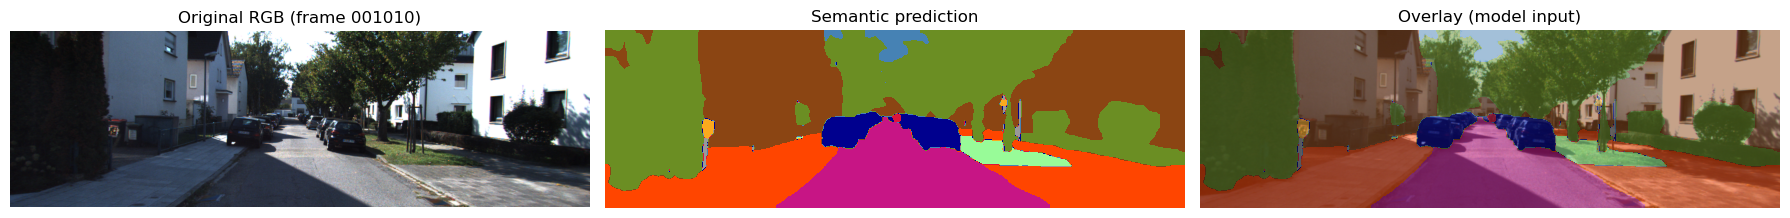

In [11]:
frame_id = 1010
show_rgb_semantic_and_3d(final_model, SEQ_DIR, frame_id)

6.2 Construction of a Global Segmented 3D Map

In [ ]:
def read_kitti_poses(poses_path: Path):
    poses = []
    with open(poses_path, "r") as f:
        for line in f:
            vals = np.fromstring(line.strip(), sep=" ", dtype=np.float64)
            T = np.eye(4, dtype=np.float64)
            T[:3, :4] = vals.reshape(3, 4)
            poses.append(T)
    return poses  

def transform_points(T, pts_xyz):
    """T: (4,4), pts_xyz: (N,3)"""
    pts1 = np.hstack([pts_xyz, np.ones((pts_xyz.shape[0], 1), dtype=pts_xyz.dtype)])
    out = (T @ pts1.T).T
    return out[:, :3]

def build_global_semantic_map(model, seq_dir, poses_path,
                             frame_ids=None, image_size=(256, 832),
                             device="cuda", voxel=0.2):
    seq_dir = Path(seq_dir)
    poses_path = Path(poses_path)

    P2, Tr_velo_to_cam0 = read_kitti_calib(seq_dir / "calib.txt")
    poses = read_kitti_poses(poses_path)

    if frame_ids is None:
        velo_dir = seq_dir / "velodyne"
        frame_ids = sorted(int(p.stem) for p in velo_dir.glob("*.bin"))

    all_pts_world = []
    all_cols = []

    for fid in frame_ids:
        #RGB, semantic
        img_path = seq_dir / "image_2" / f"{fid:06d}.png"
        pil = Image.open(img_path).convert("RGB")
        orig_wh = pil.size
        pred = predict_mask(model, pil, image_size=image_size, device=device)

        #LiDAR-cam0 + semantic
        velo_path = seq_dir / "velodyne" / f"{fid:06d}.bin"
        xyz_velo = read_velodyne_bin(velo_path)

        pts_cam0, colors, cls = project_and_color_points(
            xyz_velo, P2, Tr_velo_to_cam0, pred, orig_wh=orig_wh
        )

        #cam0-world 
        T_world_cam0 = poses[fid]
        pts_world = transform_points(T_world_cam0, pts_cam0)

        all_pts_world.append(pts_world.astype(np.float64))
        all_cols.append(colors.astype(np.float64))

    all_pts_world = np.vstack(all_pts_world)
    all_cols = np.vstack(all_cols)

    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(all_pts_world)
    pcd.colors = o3d.utility.Vector3dVector(all_cols)

    if voxel is not None and voxel > 0:
        pcd = pcd.voxel_down_sample(voxel_size=voxel)

    return pcd

In [13]:
poses_path = r"D:\Semantic Visual Odometry and 3D Scene Reconstruction\KITTI\odometry\poses\00.txt"

In [15]:
pcd_map = build_global_semantic_map(final_model, SEQ_DIR, poses_path, frame_ids=range(0,4540), voxel=0.1)
o3d.visualization.draw_geometries([pcd_map])
o3d.io.write_point_cloud("kitti00_semantic_map.ply", pcd_map)

True

In [16]:
pcd = o3d.io.read_point_cloud("kitti00_semantic_map.ply")
o3d.visualization.draw_geometries([pcd])